In [1]:
import itertools, os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from src.model_specpred import SpectrumPredictor
from src.utils_model import lorentzian, spec_to_Sqt, batch_spec_to_Sqt

from matplotlib.colors import to_rgb, to_rgba

from matplotlib.colors import Normalize
from scipy.interpolate import interp1d
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch_scatter
from tqdm import tqdm

torch.set_default_dtype(torch.float64)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

c:\Users\zhant\.conda\envs\sqt\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import config_matplotlib
import seaborn
palette_crest = seaborn.color_palette(palette='crest')
palette_flare = seaborn.color_palette(palette='flare')

In [3]:
model_spec = SpectrumPredictor.load_from_checkpoint("production_models/version_large_training_set/checkpoints/epoch=8456-step=422850.ckpt")

In [4]:
data = torch.load("data/CrI3/20221110.pt")
X = data['param'][:,:2]
Y = torch.cat((data['omega'], data['inten']), dim=1)

indices_dict = torch.load("data_splitting/indices_42_800-100-100.pt")
train_indices = indices_dict['train']
val_indices = indices_dict['val']
test_indices = indices_dict['test']

X_train = X[train_indices]
Y_train = Y[train_indices]
train_dataset = TensorDataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

X_test = X[test_indices]
Y_test = Y[test_indices]

print("print some values for further reference:")
# print("training:\n", X_train[:5])
# print("validation:\n", X_val[:5])
print("testing:\n", X_test[:5])

print some values for further reference:
testing:
 tensor([[-1.5924e+00, -2.1911e-01],
        [-2.9503e+00, -8.5994e-04],
        [-1.6105e+00, -2.4190e-01],
        [-2.3308e+00, -4.2538e-01],
        [-1.8445e+00, -5.6670e-01]])


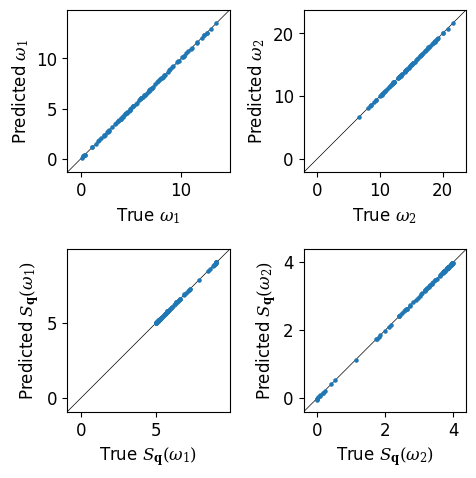

In [9]:
model_spec.to(device)

loss_test = []
Y_test_pred = []
with torch.no_grad():
    for x_test, y_test in zip(X_test, Y_test):
        y_test_pred = model_spec(x_test.to(device)).detach().cpu()
        loss_test.append((y_test_pred - y_test).abs().mean().item())
        Y_test_pred.append(y_test_pred)
Y_test_pred = torch.vstack(Y_test_pred)

labels = [r'$\omega_1$', r'$\omega_2$', r'$S_{\mathbf{q}}(\omega_{1})$', r'$S_{\mathbf{q}}(\omega_{2})$']

fig = plt.figure(figsize=(5,5))
gs = plt.GridSpec(2,2)
for i in range(4):
    ax = fig.add_subplot(gs[i])
    ax.plot([-100,100], [-100,100], 'k', linewidth=0.5, zorder=0)
    ax.scatter(Y_test[:,i], Y_test_pred[:,i], s=5, color="C0", zorder=10)
    ax.set_aspect('equal')
    ax.set_xlim([-0.1*Y_test[:,i].max(), 1.1*Y_test[:,i].max()])
    ax.set_ylim([-0.1*Y_test[:,i].max(), 1.1*Y_test[:,i].max()])
    ax.set_xlabel(f"True {labels[i]}", fontsize=12)
    ax.set_ylabel(f"Predicted {labels[i]}", fontsize=12)

fig.tight_layout()
# fig.savefig("figs/paper/network_hist2d.pdf", bbox_inches='tight')
fig.savefig("figures/network_hist2d.pdf", bbox_inches='tight')

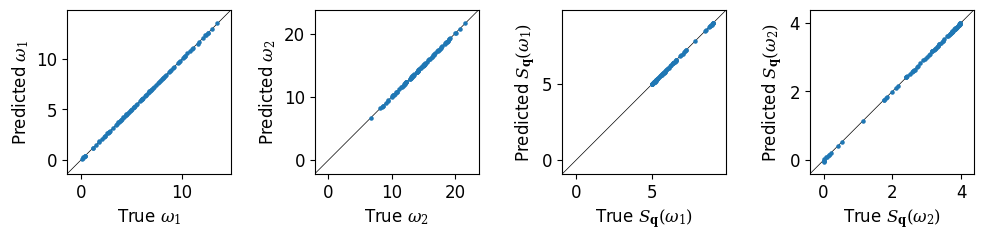

In [8]:
fig = plt.figure(figsize=(10,5))
gs = plt.GridSpec(1,4)
for i in range(4):
    ax = fig.add_subplot(gs[i])
    ax.plot([-100,100], [-100,100], 'k', linewidth=0.5, zorder=0)
    ax.scatter(Y_test[:,i], Y_test_pred[:,i], s=5, color="C0", zorder=10)
    ax.set_aspect('equal')
    ax.set_xlim([-0.1*Y_test[:,i].max(), 1.1*Y_test[:,i].max()])
    ax.set_ylim([-0.1*Y_test[:,i].max(), 1.1*Y_test[:,i].max()])
    ax.set_xlabel(f"True {labels[i]}", fontsize=12)
    ax.set_ylabel(f"Predicted {labels[i]}", fontsize=12)

fig.tight_layout()
fig.savefig("figures/network_hist2d.pdf", bbox_inches='tight')

In [24]:
from sklearn.neighbors import KernelDensity

In [114]:
J_grid, D_grid = np.meshgrid(np.linspace(-3,-1,401),np.linspace(-1,0,201))
X_grid = np.concatenate([J_grid[...,None], D_grid[...,None]], axis=-1).reshape(-1,2)

In [115]:
test_error = (Y_test_pred - Y_test).abs().mean(dim=1)

In [119]:
from scipy.interpolate import griddata

test_error_grid = griddata(X_test, test_error, (J_grid, D_grid), method='cubic').clip(0.)

In [117]:
kde = KernelDensity(kernel="exponential", bandwidth=0.05).fit(X_test, sample_weight=test_error)
log_dens = kde.score_samples(X_grid).reshape(J_grid.shape)

In [145]:
normed_test_error = (test_error - test_error.min()) / np.ptp(test_error)
normed_test_error = 50 + 300 * normed_test_error

TypeError: set_xlabel() missing 1 required positional argument: 'xlabel'

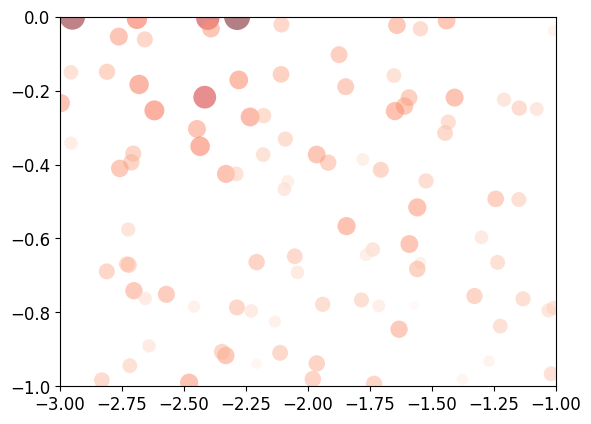

In [159]:
fig, ax = plt.subplots(1,1)
# ax.imshow(test_error_grid, extent=[-3, -1, -1, 0], origin='lower', cmap='Blues')
# ax.scatter(X_train[:,0], X_train[:,1], s=10, color='k', linewidths=0., alpha=0.5)
ax.scatter(X_test[:,0], X_test[:,1], s=normed_test_error, c=test_error, linewidths=0., alpha=0.5, cmap='Reds')
ax.set_xlim([-3,-1])
ax.set_ylim([-1, 0])
ax.set_xlabel()

In [55]:
Nb = 40
noise_level_list = [0.5, 1.0, 2.0]
pw_list = [0.1, 0.2]
datadir = 'benchmarks_2023May01'
task_labels = ['gd', 'baseline', 'sequential', 'random']
run_labels = [f'RUN_{i+1}' for i in range(5)]
scatter_mean_indices = torch.arange(len(task_labels)).repeat_interleave(len(run_labels))
print(scatter_mean_indices)

results = torch.load(os.path.join(datadir, "summarized_results.pt"))
print(results.keys())
print(results[(0.1,0.5)].keys())

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3])
dict_keys([(0.1, 0.5), (0.1, 1.0), (0.1, 2.0), (0.2, 0.5), (0.2, 1.0), (0.2, 2.0)])
dict_keys(['mean_loss_avg_over_runs_samples', 'std_loss_avg_over_runs_samples', 'loss_avg_over_runs', 'loss_full', 'loss_indices', 'param_true', 'times', 'signals', 'measured_settings', 'measured_values', 'times_finer', 'signals_finer'])


In [56]:
results[(0.1,0.5)]['loss_full'][...,-1,:2].mean(-1)

tensor([[0.0051, 0.1582, 0.0147,  ..., 0.0068, 0.3128, 0.8614],
        [0.0068, 0.6985, 0.0018,  ..., 0.0065, 0.0198, 0.3268],
        [0.0303, 1.2834, 0.0027,  ..., 0.0075, 0.0249, 0.8828],
        ...,
        [0.0132, 0.6307, 0.0045,  ..., 0.0313, 0.0103, 0.9190],
        [0.4864, 0.7518, 0.3972,  ..., 0.0335, 0.0689, 0.4470],
        [0.0123, 1.2967, 0.0163,  ..., 0.0065, 0.0043, 0.2624]],
       dtype=torch.float32)

In [71]:
last_iter_error = 0.
for key in results.keys():
    last_iter_error += results[key]['loss_full'][...,-1,:2].mean(-1)
last_iter_error /= len(results.keys())
last_iter_error = torch_scatter.scatter_mean(last_iter_error, scatter_mean_indices, dim=0)

In [100]:
kde_error = KernelDensity(kernel="exponential", bandwidth=0.15).fit(X_test, sample_weight=last_iter_error[2])
log_dens_error = kde_error.score_samples(X_grid).reshape(J_grid.shape)

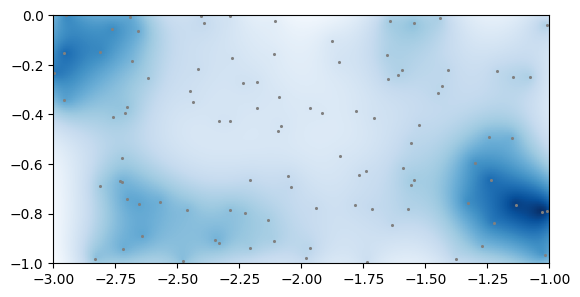

In [101]:
fig, ax = plt.subplots(1,1)
ax.imshow(np.exp(log_dens_error), extent=[-3, -1, -1, 0], origin='lower', cmap='Blues')
ax.scatter(X_test[:,0], X_test[:,1], s=5, linewidths=0, color='gray')

In [77]:
np.allclose(log_dens_error, log_dens)

True

In [83]:
last_iter_error[0]

tensor([0.0952, 0.8626, 0.0085, 0.0364, 0.0764, 0.0528, 0.0917, 0.1588, 0.0688,
        0.2781, 0.5641, 0.0343, 0.0439, 0.0486, 0.2658, 0.0276, 0.1511, 0.2808,
        0.0589, 0.0369, 0.2667, 0.0254, 0.4931, 0.0332, 0.0839, 0.0417, 0.1247,
        0.0859, 0.0577, 0.1980, 0.0392, 0.0439, 0.0886, 0.1344, 0.0145, 0.0508,
        0.0450, 0.0332, 0.0850, 0.5863, 0.0139, 0.0262, 0.0288, 0.1221, 0.0213,
        0.0147, 0.2828, 0.0186, 0.2159, 0.0175, 0.0267, 0.0658, 0.1605, 0.3094,
        0.0449, 0.1493, 0.0385, 0.0661, 0.1247, 0.0625, 0.0352, 0.2197, 0.2324,
        0.1156, 0.0419, 0.0740, 0.0670, 0.1645, 0.1013, 0.0439, 0.0417, 0.0917,
        0.2563, 0.0170, 0.0711, 0.0367, 0.0596, 0.3649, 0.0673, 0.4811, 0.0603,
        0.2659, 0.1724, 0.0461, 0.0716, 0.1482, 0.0538, 0.5805, 0.0304, 0.0977,
        0.0354, 0.0291, 0.0692, 0.2552, 0.0249, 0.0273, 0.1687, 0.0131, 0.0563,
        0.2558], dtype=torch.float32)

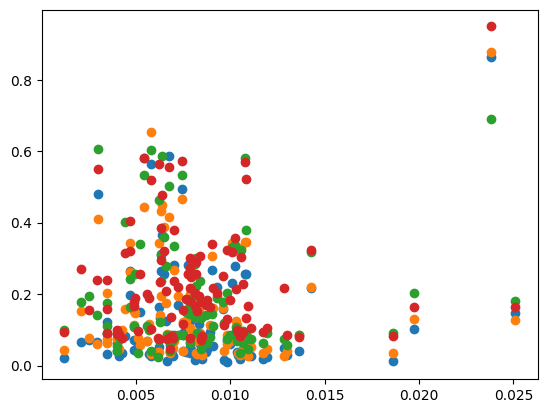

In [154]:
plt.scatter(test_error, last_iter_error[0])
plt.scatter(test_error, last_iter_error[1])
plt.scatter(test_error, last_iter_error[2])
plt.scatter(test_error, last_iter_error[3])